In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sympy import fraction
from torch.ao.nn.quantized.functional import threshold
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.optim as optim


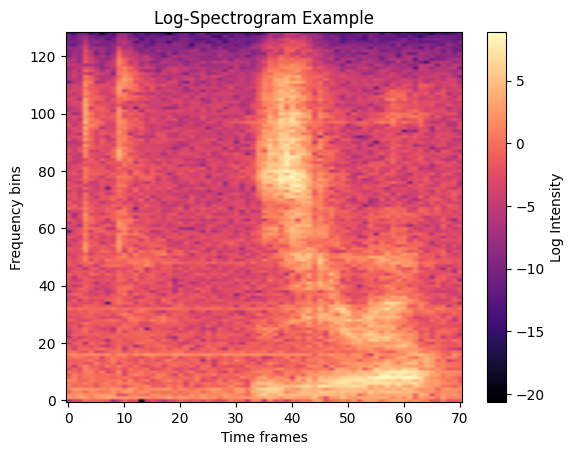

In [2]:
y = np.load('y_digits.npy')
x = np.load('X_digits.npy')

plt.imshow(x[2], aspect='auto', origin='lower', cmap='magma')
plt.colorbar(label="Log Intensity")
plt.xlabel("Time frames")
plt.ylabel("Frequency bins")
plt.title("Log-Spectrogram Example")
plt.show()

In [3]:
X_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(dim=1)
Y_tensor = torch.tensor(y, dtype=torch.float32)

dataset_size = len(X_tensor)

from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, Y_tensor, test_size=0.3, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

torch.Size([24941, 1, 129, 71]) torch.Size([5345, 1, 129, 71]) torch.Size([5345, 1, 129, 71]) torch.Size([24941]) torch.Size([5345]) torch.Size([5345])


In [4]:
import torch.nn as nn


def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.classes = 10
        conv_blks = []
        for i in range(3):
            conv_blks.append(vgg_block(3, 256))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
        )

        dummy_input = torch.zeros(1, 1, 129, 71)
        dummy_input.to("cuda")
        with torch.no_grad():
            self.net_output = self.net(dummy_input).size(1)

        self.detection_head = nn.Sequential(
            nn.LazyLinear(4096), nn.ReLU(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(10)
        )

    def forward(self, x):
        x = self.net(x)

        logits = self.detection_head(x)
        pred_digits = torch.argmax(logits, dim=1)
        return logits, pred_digits


In [5]:
batch_size = 128
device = "cuda"

X_reduced, X_left, y_reduced, y_left = train_test_split(X_temp, y_temp, test_size=0.85, stratify=y_temp)
X_val_reduced, X_val_left, y_val_reduced, y_val_left = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val)

dataset = TensorDataset(X_train, y_train)
full_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



In [16]:
from torch.utils.data import SubsetRandomSampler

model = Net().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 10

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True, threshold=0.01)

patience = 3
threshold = 0.01
best_val_loss = 9999999
counter = 0
subset_size = int(0.3 * len(dataset))
val_losses = []
train_losses = []

for epoch in range(num_epochs):

    dataloader = full_dataloader
    fraction = 0.3
    actual_batches = 0
    discarded_batches = 0
    discard_limit = (1 - fraction) * len(dataloader)
    model.train()
    total_loss = 0.0
    for images, targets in tqdm(dataloader):
        if torch.rand(1).item() > fraction and discarded_batches < discard_limit:
            discarded_batches += 1
            continue
        actual_batches += 1
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True).type(torch.long)

        optimizer.zero_grad()
        logits, arg_max_pred = model(images)

        loss = loss_fn(logits, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        print(f": Loss = {loss.item():.4f}, actual_batches = {actual_batches}")

    avg_loss = total_loss / actual_batches
    print(f":Epoch finished, looking at validation set...")

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in val_dataloader:
            images = images.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True).long()

            logits, _ = model(images)
            loss = loss_fn(logits, targets)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)

    scheduler.step(avg_val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {avg_loss:.4f}, Val Loss = {avg_val_loss:.4f},  lr = {optimizer.param_groups[0]['lr']}")
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)

    if best_val_loss - avg_val_loss > threshold:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model.")
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), "Net_best.pth")
    else:
        print(f"No significant improvement in validation loss. Best: {best_val_loss:.4f}, Current: {avg_val_loss:.4f} for {counter+1} epochs.")
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break


/home/user/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
  5%|▍         | 9/195 [00:02<01:01,  3.04it/s]

: Loss = 2.3039, actual_batches = 1


  6%|▌         | 11/195 [00:05<01:49,  1.68it/s]

: Loss = 2.3027, actual_batches = 2


  6%|▌         | 12/195 [00:08<02:49,  1.08it/s]

: Loss = 2.3034, actual_batches = 3


  7%|▋         | 13/195 [00:11<03:49,  1.26s/it]

: Loss = 2.3024, actual_batches = 4


  9%|▉         | 18/195 [00:14<02:35,  1.14it/s]

: Loss = 2.3059, actual_batches = 5


 12%|█▏        | 24/195 [00:17<01:56,  1.46it/s]

: Loss = 2.3056, actual_batches = 6


 16%|█▋        | 32/195 [00:20<01:25,  1.90it/s]

: Loss = 2.3005, actual_batches = 7


 17%|█▋        | 33/195 [00:22<01:55,  1.40it/s]

: Loss = 2.2990, actual_batches = 8


 22%|██▏       | 43/195 [00:28<01:36,  1.57it/s]

: Loss = 2.3023, actual_batches = 9


 25%|██▍       | 48/195 [00:31<01:31,  1.60it/s]

: Loss = 2.2960, actual_batches = 10


 27%|██▋       | 52/195 [00:34<01:32,  1.55it/s]

: Loss = 2.2719, actual_batches = 11


 28%|██▊       | 54/195 [00:37<01:47,  1.31it/s]

: Loss = 2.2705, actual_batches = 12


 35%|███▍      | 68/195 [00:40<00:54,  2.32it/s]

: Loss = 2.2713, actual_batches = 13


 36%|███▌      | 70/195 [00:43<01:07,  1.85it/s]

: Loss = 2.1751, actual_batches = 14


 37%|███▋      | 73/195 [00:45<01:15,  1.62it/s]

: Loss = 2.0566, actual_batches = 15


 38%|███▊      | 75/195 [00:48<01:28,  1.35it/s]

: Loss = 2.1917, actual_batches = 16


 39%|███▉      | 76/195 [00:51<01:52,  1.05it/s]

: Loss = 2.0325, actual_batches = 17


 45%|████▍     | 87/195 [00:54<00:57,  1.88it/s]

: Loss = 1.8639, actual_batches = 18


 47%|████▋     | 92/195 [00:57<00:56,  1.84it/s]

: Loss = 2.0515, actual_batches = 19


 48%|████▊     | 93/195 [01:03<01:33,  1.09it/s]

: Loss = 1.8375, actual_batches = 20


 50%|█████     | 98/195 [01:06<01:18,  1.24it/s]

: Loss = 1.8219, actual_batches = 21


 52%|█████▏    | 101/195 [01:08<01:19,  1.19it/s]

: Loss = 1.8977, actual_batches = 22


 55%|█████▌    | 108/195 [01:11<00:56,  1.53it/s]

: Loss = 1.9333, actual_batches = 23


 56%|█████▌    | 109/195 [01:14<01:11,  1.20it/s]

: Loss = 1.8512, actual_batches = 24


 57%|█████▋    | 112/195 [01:17<01:11,  1.16it/s]

: Loss = 1.9755, actual_batches = 25


 59%|█████▉    | 116/195 [01:20<01:04,  1.23it/s]

: Loss = 1.9021, actual_batches = 26


 61%|██████    | 118/195 [01:23<01:11,  1.07it/s]

: Loss = 1.7868, actual_batches = 27


 63%|██████▎   | 122/195 [01:26<01:02,  1.17it/s]

: Loss = 1.7000, actual_batches = 28


 64%|██████▎   | 124/195 [01:28<01:08,  1.03it/s]

: Loss = 1.8006, actual_batches = 29


 65%|██████▌   | 127/195 [01:31<01:05,  1.04it/s]

: Loss = 1.9280, actual_batches = 30


 66%|██████▌   | 129/195 [01:37<01:31,  1.38s/it]

: Loss = 1.6422, actual_batches = 31


 67%|██████▋   | 131/195 [01:40<01:30,  1.41s/it]

: Loss = 1.7111, actual_batches = 32


 68%|██████▊   | 133/195 [01:43<01:27,  1.42s/it]

: Loss = 1.6721, actual_batches = 33


 71%|███████▏  | 139/195 [01:46<00:51,  1.08it/s]

: Loss = 1.6431, actual_batches = 34


 72%|███████▏  | 141/195 [01:49<00:55,  1.03s/it]

: Loss = 1.8345, actual_batches = 35


 74%|███████▍  | 144/195 [01:51<00:51,  1.00s/it]

: Loss = 1.6599, actual_batches = 36


 75%|███████▌  | 147/195 [01:54<00:47,  1.01it/s]

: Loss = 1.6637, actual_batches = 37


 78%|███████▊  | 153/195 [01:57<00:31,  1.33it/s]

: Loss = 1.4100, actual_batches = 38


 79%|███████▉  | 155/195 [02:00<00:34,  1.14it/s]

: Loss = 1.4407, actual_batches = 39


 83%|████████▎ | 161/195 [02:03<00:23,  1.43it/s]

: Loss = 1.4530, actual_batches = 40


 84%|████████▍ | 164/195 [02:06<00:23,  1.31it/s]

: Loss = 1.4012, actual_batches = 41


 87%|████████▋ | 170/195 [02:09<00:16,  1.55it/s]

: Loss = 1.3997, actual_batches = 42


 89%|████████▊ | 173/195 [02:14<00:20,  1.07it/s]

: Loss = 1.5613, actual_batches = 43


 89%|████████▉ | 174/195 [02:17<00:23,  1.12s/it]

: Loss = 1.3156, actual_batches = 44


 90%|█████████ | 176/195 [02:20<00:22,  1.18s/it]

: Loss = 1.3752, actual_batches = 45


 91%|█████████ | 177/195 [02:23<00:25,  1.41s/it]

: Loss = 1.2243, actual_batches = 46


 91%|█████████▏| 178/195 [02:26<00:27,  1.64s/it]

: Loss = 1.3118, actual_batches = 47


 92%|█████████▏| 179/195 [02:29<00:29,  1.87s/it]

: Loss = 1.1307, actual_batches = 48


 92%|█████████▏| 180/195 [02:31<00:31,  2.08s/it]

: Loss = 1.3526, actual_batches = 49


 96%|█████████▌| 187/195 [02:34<00:07,  1.06it/s]

: Loss = 1.1856, actual_batches = 50


 96%|█████████▋| 188/195 [02:37<00:08,  1.18s/it]

: Loss = 1.1855, actual_batches = 51


 97%|█████████▋| 189/195 [02:40<00:08,  1.43s/it]

: Loss = 1.0124, actual_batches = 52


 97%|█████████▋| 190/195 [02:43<00:08,  1.68s/it]

: Loss = 1.1127, actual_batches = 53


 98%|█████████▊| 191/195 [02:49<00:09,  2.49s/it]

: Loss = 1.1176, actual_batches = 54


 98%|█████████▊| 192/195 [02:52<00:07,  2.58s/it]

: Loss = 1.1559, actual_batches = 55


 99%|█████████▉| 193/195 [02:54<00:05,  2.64s/it]

: Loss = 1.1253, actual_batches = 56


 99%|█████████▉| 194/195 [02:57<00:02,  2.70s/it]

: Loss = 1.0263, actual_batches = 57


100%|██████████| 195/195 [03:00<00:00,  1.08it/s]

: Loss = 0.9567, actual_batches = 58
:Epoch finished, looking at validation set...


Epoch 1: Train Loss = 1.7366, Val Loss = 1.0456,  lr = 0.0001
Validation loss improved from 9999999.0000 to 1.0456. Saving model.


  2%|▏         | 4/195 [00:03<02:32,  1.26it/s]

: Loss = 0.9526, actual_batches = 1


  4%|▎         | 7/195 [00:06<02:45,  1.14it/s]

: Loss = 0.9613, actual_batches = 2


  4%|▍         | 8/195 [00:08<03:57,  1.27s/it]

: Loss = 1.1860, actual_batches = 3


  6%|▌         | 11/195 [00:14<04:47,  1.56s/it]

: Loss = 1.0009, actual_batches = 4


  7%|▋         | 13/195 [00:17<04:39,  1.54s/it]

: Loss = 0.8327, actual_batches = 5


  8%|▊         | 15/195 [00:20<04:30,  1.50s/it]

: Loss = 1.0343, actual_batches = 6


  8%|▊         | 16/195 [00:23<05:12,  1.74s/it]

: Loss = 0.9717, actual_batches = 7


 10%|▉         | 19/195 [00:26<04:06,  1.40s/it]

: Loss = 0.8673, actual_batches = 8


 20%|██        | 39/195 [00:29<01:00,  2.56it/s]

: Loss = 0.9503, actual_batches = 9


 22%|██▏       | 42/195 [00:31<01:12,  2.11it/s]

: Loss = 0.9346, actual_batches = 10


 23%|██▎       | 44/195 [00:34<01:29,  1.69it/s]

: Loss = 0.8397, actual_batches = 11


 23%|██▎       | 45/195 [00:37<01:56,  1.29it/s]

: Loss = 0.8029, actual_batches = 12


 24%|██▍       | 47/195 [00:40<02:12,  1.11it/s]

: Loss = 0.7549, actual_batches = 13


 27%|██▋       | 53/195 [00:43<01:40,  1.41it/s]

: Loss = 0.6520, actual_batches = 14


 28%|██▊       | 54/195 [00:49<02:47,  1.19s/it]

: Loss = 0.7971, actual_batches = 15


 29%|██▊       | 56/195 [00:52<02:53,  1.25s/it]

: Loss = 0.8043, actual_batches = 16


 30%|███       | 59/195 [00:54<02:37,  1.16s/it]

: Loss = 0.8023, actual_batches = 17


 31%|███▏      | 61/195 [00:57<02:43,  1.22s/it]

: Loss = 0.6179, actual_batches = 18


 34%|███▍      | 67/195 [01:00<01:48,  1.17it/s]

: Loss = 0.6428, actual_batches = 19


 37%|███▋      | 72/195 [01:03<01:32,  1.34it/s]

: Loss = 0.6574, actual_batches = 20


 37%|███▋      | 73/195 [01:06<01:56,  1.05it/s]

: Loss = 0.5022, actual_batches = 21


 39%|███▉      | 76/195 [01:09<01:53,  1.05it/s]

: Loss = 0.7008, actual_batches = 22


 41%|████      | 80/195 [01:12<01:39,  1.15it/s]

: Loss = 0.6845, actual_batches = 23


 43%|████▎     | 84/195 [01:14<01:30,  1.22it/s]

: Loss = 0.7798, actual_batches = 24


 44%|████▎     | 85/195 [01:17<01:54,  1.04s/it]

: Loss = 0.6231, actual_batches = 25


 45%|████▌     | 88/195 [01:20<01:48,  1.02s/it]

: Loss = 0.6827, actual_batches = 26


 47%|████▋     | 91/195 [01:26<02:14,  1.29s/it]

: Loss = 0.7124, actual_batches = 27


 48%|████▊     | 93/195 [01:29<02:15,  1.33s/it]

: Loss = 0.6774, actual_batches = 28


 51%|█████     | 99/195 [01:32<01:27,  1.09it/s]

: Loss = 0.6846, actual_batches = 29


 53%|█████▎    | 103/195 [01:35<01:18,  1.17it/s]

: Loss = 0.5240, actual_batches = 30


 53%|█████▎    | 104/195 [01:38<01:36,  1.06s/it]

: Loss = 0.5915, actual_batches = 31


 54%|█████▍    | 105/195 [01:40<01:56,  1.29s/it]

: Loss = 0.7216, actual_batches = 32


 56%|█████▌    | 109/195 [01:43<01:30,  1.05s/it]

: Loss = 0.7113, actual_batches = 33


 56%|█████▋    | 110/195 [01:46<01:49,  1.29s/it]

: Loss = 0.5294, actual_batches = 34


 62%|██████▏   | 121/195 [01:49<00:44,  1.68it/s]

: Loss = 0.6522, actual_batches = 35


 68%|██████▊   | 132/195 [01:52<00:27,  2.31it/s]

: Loss = 0.5242, actual_batches = 36


 71%|███████▏  | 139/195 [01:55<00:23,  2.35it/s]

: Loss = 0.5365, actual_batches = 37


 76%|███████▌  | 148/195 [02:00<00:23,  2.02it/s]

: Loss = 0.7548, actual_batches = 38


 78%|███████▊  | 153/195 [02:03<00:21,  1.93it/s]

: Loss = 0.5556, actual_batches = 39


 79%|███████▉  | 154/195 [02:06<00:27,  1.51it/s]

: Loss = 0.3846, actual_batches = 40


 79%|███████▉  | 155/195 [02:09<00:33,  1.19it/s]

: Loss = 0.5885, actual_batches = 41


 80%|████████  | 156/195 [02:12<00:40,  1.04s/it]

: Loss = 0.5040, actual_batches = 42


 85%|████████▍ | 165/195 [02:15<00:18,  1.58it/s]

: Loss = 0.5247, actual_batches = 43


 85%|████████▌ | 166/195 [02:18<00:23,  1.22it/s]

: Loss = 0.3247, actual_batches = 44


 86%|████████▌ | 168/195 [02:21<00:25,  1.07it/s]

: Loss = 0.6133, actual_batches = 45


 92%|█████████▏| 179/195 [02:23<00:08,  1.89it/s]

: Loss = 0.4990, actual_batches = 46


 93%|█████████▎| 181/195 [02:26<00:09,  1.53it/s]

: Loss = 0.7402, actual_batches = 47


 94%|█████████▍| 184/195 [02:29<00:07,  1.39it/s]

: Loss = 0.5156, actual_batches = 48


 95%|█████████▌| 186/195 [02:35<00:09,  1.08s/it]

: Loss = 0.3965, actual_batches = 49


 96%|█████████▌| 187/195 [02:38<00:10,  1.29s/it]

: Loss = 0.5331, actual_batches = 50


 96%|█████████▋| 188/195 [02:41<00:10,  1.52s/it]

: Loss = 0.6471, actual_batches = 51


 97%|█████████▋| 189/195 [02:44<00:10,  1.75s/it]

: Loss = 0.4590, actual_batches = 52


 97%|█████████▋| 190/195 [02:46<00:09,  1.96s/it]

: Loss = 0.4052, actual_batches = 53


 98%|█████████▊| 191/195 [02:49<00:08,  2.15s/it]

: Loss = 0.4443, actual_batches = 54


 98%|█████████▊| 192/195 [02:52<00:06,  2.32s/it]

: Loss = 0.3417, actual_batches = 55


 99%|█████████▉| 193/195 [02:55<00:04,  2.46s/it]

: Loss = 0.5671, actual_batches = 56


 99%|█████████▉| 194/195 [02:58<00:02,  2.56s/it]

: Loss = 0.4436, actual_batches = 57


100%|██████████| 195/195 [03:00<00:00,  1.08it/s]

: Loss = 0.3922, actual_batches = 58
:Epoch finished, looking at validation set...


Epoch 2: Train Loss = 0.6644, Val Loss = 0.4528,  lr = 0.0001
Validation loss improved from 1.0456 to 0.4528. Saving model.


  1%|          | 1/195 [00:03<10:16,  3.18s/it]

: Loss = 0.3257, actual_batches = 1


  3%|▎         | 6/195 [00:06<02:50,  1.11it/s]

: Loss = 0.3569, actual_batches = 2


  4%|▍         | 8/195 [00:08<03:21,  1.08s/it]

: Loss = 0.4166, actual_batches = 3


  5%|▍         | 9/195 [00:11<04:24,  1.42s/it]

: Loss = 0.4094, actual_batches = 4


  6%|▌         | 12/195 [00:14<03:41,  1.21s/it]

: Loss = 0.5842, actual_batches = 5


  7%|▋         | 13/195 [00:17<04:33,  1.50s/it]

: Loss = 0.3200, actual_batches = 6


  7%|▋         | 14/195 [00:20<05:21,  1.78s/it]

: Loss = 0.4206, actual_batches = 7


  9%|▊         | 17/195 [00:23<04:08,  1.39s/it]

: Loss = 0.4063, actual_batches = 8


  9%|▉         | 18/195 [00:26<04:53,  1.66s/it]

: Loss = 0.3880, actual_batches = 9


 10%|█         | 20/195 [00:28<04:36,  1.58s/it]

: Loss = 0.3513, actual_batches = 10


 11%|█▏        | 22/195 [00:34<05:41,  1.98s/it]

: Loss = 0.5405, actual_batches = 11


 12%|█▏        | 23/195 [00:37<06:11,  2.16s/it]

: Loss = 0.4875, actual_batches = 12


 15%|█▌        | 30/195 [00:40<02:48,  1.02s/it]

: Loss = 0.4077, actual_batches = 13


 16%|█▋        | 32/195 [00:43<03:00,  1.11s/it]

: Loss = 0.3339, actual_batches = 14


 18%|█▊        | 35/195 [00:46<02:49,  1.06s/it]

: Loss = 0.4524, actual_batches = 15


 19%|█▉        | 38/195 [00:49<02:41,  1.03s/it]

: Loss = 0.3814, actual_batches = 16


 20%|██        | 39/195 [00:51<03:16,  1.26s/it]

: Loss = 0.2648, actual_batches = 17


 25%|██▍       | 48/195 [00:54<01:39,  1.48it/s]

: Loss = 0.3291, actual_batches = 18


 27%|██▋       | 53/195 [00:57<01:31,  1.56it/s]

: Loss = 0.3716, actual_batches = 19


 28%|██▊       | 55/195 [01:00<01:47,  1.30it/s]

: Loss = 0.3560, actual_batches = 20


 29%|██▊       | 56/195 [01:03<02:16,  1.02it/s]

: Loss = 0.3624, actual_batches = 21


 31%|███       | 60/195 [01:08<02:33,  1.14s/it]

: Loss = 0.3717, actual_batches = 22


 33%|███▎      | 65/195 [01:11<01:59,  1.08it/s]

: Loss = 0.3495, actual_batches = 23


 35%|███▌      | 69/195 [01:14<01:48,  1.16it/s]

: Loss = 0.4667, actual_batches = 24


 39%|███▉      | 76/195 [01:17<01:19,  1.50it/s]

: Loss = 0.4464, actual_batches = 25


 40%|████      | 78/195 [01:20<01:31,  1.28it/s]

: Loss = 0.3586, actual_batches = 26


 42%|████▏     | 81/195 [01:23<01:33,  1.21it/s]

: Loss = 0.4976, actual_batches = 27


 44%|████▎     | 85/195 [01:26<01:26,  1.27it/s]

: Loss = 0.3847, actual_batches = 28


 45%|████▌     | 88/195 [01:29<01:28,  1.20it/s]

: Loss = 0.3760, actual_batches = 29


 46%|████▌     | 90/195 [01:32<01:39,  1.06it/s]

: Loss = 0.2435, actual_batches = 30


 47%|████▋     | 92/195 [01:34<01:48,  1.05s/it]

: Loss = 0.2268, actual_batches = 31


 48%|████▊     | 94/195 [01:37<01:55,  1.14s/it]

: Loss = 0.2795, actual_batches = 32


 52%|█████▏    | 102/195 [01:43<01:22,  1.13it/s]

: Loss = 0.3304, actual_batches = 33


 53%|█████▎    | 104/195 [01:46<01:29,  1.02it/s]

: Loss = 0.2979, actual_batches = 34


 54%|█████▍    | 105/195 [01:49<01:49,  1.21s/it]

: Loss = 0.2970, actual_batches = 35


 56%|█████▋    | 110/195 [01:52<01:19,  1.07it/s]

: Loss = 0.2219, actual_batches = 36


 58%|█████▊    | 113/195 [01:55<01:17,  1.06it/s]

: Loss = 0.4248, actual_batches = 37


 58%|█████▊    | 114/195 [01:57<01:33,  1.16s/it]

: Loss = 0.3167, actual_batches = 38


 59%|█████▉    | 115/195 [02:00<01:51,  1.40s/it]

: Loss = 0.3106, actual_batches = 39


 61%|██████    | 118/195 [02:03<01:34,  1.23s/it]

: Loss = 0.2419, actual_batches = 40


 62%|██████▏   | 121/195 [02:06<01:23,  1.13s/it]

: Loss = 0.3818, actual_batches = 41


 64%|██████▎   | 124/195 [02:09<01:16,  1.07s/it]

: Loss = 0.2943, actual_batches = 42


 65%|██████▍   | 126/195 [02:12<01:20,  1.16s/it]

: Loss = 0.3383, actual_batches = 43


 65%|██████▌   | 127/195 [02:17<02:01,  1.79s/it]

: Loss = 0.2960, actual_batches = 44


 67%|██████▋   | 130/195 [02:20<01:36,  1.48s/it]

: Loss = 0.3694, actual_batches = 45


 68%|██████▊   | 132/195 [02:23<01:34,  1.50s/it]

: Loss = 0.3371, actual_batches = 46


 68%|██████▊   | 133/195 [02:26<01:46,  1.72s/it]

: Loss = 0.3574, actual_batches = 47


 69%|██████▊   | 134/195 [02:29<01:58,  1.93s/it]

: Loss = 0.3502, actual_batches = 48


 72%|███████▏  | 141/195 [02:32<00:50,  1.06it/s]

: Loss = 0.3670, actual_batches = 49


 75%|███████▍  | 146/195 [02:35<00:39,  1.26it/s]

: Loss = 0.3126, actual_batches = 50


 76%|███████▌  | 148/195 [02:38<00:42,  1.09it/s]

: Loss = 0.4880, actual_batches = 51


 86%|████████▌ | 168/195 [02:41<00:09,  2.82it/s]

: Loss = 0.3357, actual_batches = 52


 87%|████████▋ | 170/195 [02:43<00:11,  2.19it/s]

: Loss = 0.3481, actual_batches = 53


 88%|████████▊ | 172/195 [02:46<00:13,  1.75it/s]

: Loss = 0.2477, actual_batches = 54


 89%|████████▊ | 173/195 [02:52<00:20,  1.05it/s]

: Loss = 0.4457, actual_batches = 55


 94%|█████████▍| 184/195 [02:55<00:06,  1.75it/s]

: Loss = 0.3280, actual_batches = 56


 96%|█████████▌| 187/195 [02:58<00:05,  1.52it/s]

: Loss = 0.3121, actual_batches = 57


100%|██████████| 195/195 [03:01<00:00,  1.08it/s]

: Loss = 0.3075, actual_batches = 58
:Epoch finished, looking at validation set...


Epoch 3: Train Loss = 0.3608, Val Loss = 0.3309,  lr = 0.0001
Validation loss improved from 0.4528 to 0.3309. Saving model.


  1%|          | 2/195 [00:03<04:56,  1.54s/it]

: Loss = 0.3835, actual_batches = 1


  2%|▏         | 3/195 [00:05<06:40,  2.09s/it]

: Loss = 0.3782, actual_batches = 2


  5%|▌         | 10/195 [00:08<02:15,  1.36it/s]

: Loss = 0.3374, actual_batches = 3


  9%|▊         | 17/195 [00:11<01:39,  1.78it/s]

: Loss = 0.3247, actual_batches = 4


  9%|▉         | 18/195 [00:17<03:04,  1.04s/it]

: Loss = 0.3205, actual_batches = 5


 10%|█         | 20/195 [00:19<03:17,  1.13s/it]

: Loss = 0.2144, actual_batches = 6


 15%|█▍        | 29/195 [00:23<01:51,  1.49it/s]

: Loss = 0.1903, actual_batches = 7


 17%|█▋        | 33/195 [00:26<01:51,  1.46it/s]

: Loss = 0.2263, actual_batches = 8


 17%|█▋        | 34/195 [00:28<02:21,  1.14it/s]

: Loss = 0.2204, actual_batches = 9


 18%|█▊        | 35/195 [00:31<02:55,  1.10s/it]

: Loss = 0.1704, actual_batches = 10


 18%|█▊        | 36/195 [00:34<03:33,  1.34s/it]

: Loss = 0.1977, actual_batches = 11


 20%|██        | 39/195 [00:37<03:07,  1.20s/it]

: Loss = 0.2532, actual_batches = 12


 22%|██▏       | 43/195 [00:40<02:32,  1.00s/it]

: Loss = 0.1978, actual_batches = 13


 23%|██▎       | 45/195 [00:43<02:45,  1.10s/it]

: Loss = 0.2313, actual_batches = 14


 24%|██▎       | 46/195 [00:46<03:20,  1.35s/it]

: Loss = 0.0796, actual_batches = 15


 24%|██▍       | 47/195 [00:48<03:57,  1.60s/it]

: Loss = 0.1887, actual_batches = 16


 26%|██▌       | 50/195 [00:54<04:05,  1.69s/it]

: Loss = 0.1991, actual_batches = 17


 28%|██▊       | 55/195 [00:57<02:42,  1.16s/it]

: Loss = 0.2268, actual_batches = 18


 30%|██▉       | 58/195 [01:00<02:31,  1.11s/it]

: Loss = 0.1763, actual_batches = 19


 31%|███       | 60/195 [01:03<02:39,  1.18s/it]

: Loss = 0.2371, actual_batches = 20


 32%|███▏      | 62/195 [01:06<02:45,  1.24s/it]

: Loss = 0.3217, actual_batches = 21


 35%|███▌      | 69/195 [01:09<01:39,  1.27it/s]

: Loss = 0.3046, actual_batches = 22


 36%|███▋      | 71/195 [01:11<01:52,  1.10it/s]

: Loss = 0.2342, actual_batches = 23


 37%|███▋      | 73/195 [01:14<02:03,  1.01s/it]

: Loss = 0.2848, actual_batches = 24


 38%|███▊      | 74/195 [01:17<02:31,  1.25s/it]

: Loss = 0.1903, actual_batches = 25


 43%|████▎     | 84/195 [01:20<01:09,  1.59it/s]

: Loss = 0.2600, actual_batches = 26


 51%|█████     | 99/195 [01:23<00:35,  2.67it/s]

: Loss = 0.1782, actual_batches = 27


 51%|█████▏    | 100/195 [01:28<01:01,  1.56it/s]

: Loss = 0.2447, actual_batches = 28


 52%|█████▏    | 102/195 [01:32<01:10,  1.31it/s]

: Loss = 0.1281, actual_batches = 29


 53%|█████▎    | 104/195 [01:34<01:19,  1.15it/s]

: Loss = 0.2479, actual_batches = 30


 56%|█████▌    | 109/195 [01:37<01:05,  1.31it/s]

: Loss = 0.3403, actual_batches = 31


 57%|█████▋    | 112/195 [01:40<01:07,  1.23it/s]

: Loss = 0.0997, actual_batches = 32


 66%|██████▌   | 128/195 [01:43<00:27,  2.46it/s]

: Loss = 0.2229, actual_batches = 33


 70%|███████   | 137/195 [01:46<00:21,  2.66it/s]

: Loss = 0.1896, actual_batches = 34


 72%|███████▏  | 140/195 [01:49<00:25,  2.19it/s]

: Loss = 0.2905, actual_batches = 35


 72%|███████▏  | 141/195 [01:52<00:32,  1.65it/s]

: Loss = 0.1727, actual_batches = 36


 74%|███████▍  | 144/195 [01:55<00:34,  1.47it/s]

: Loss = 0.2516, actual_batches = 37


 76%|███████▋  | 149/195 [01:57<00:29,  1.55it/s]

: Loss = 0.3575, actual_batches = 38


 77%|███████▋  | 150/195 [02:03<00:47,  1.07s/it]

: Loss = 0.2723, actual_batches = 39


 77%|███████▋  | 151/195 [02:06<00:56,  1.29s/it]

: Loss = 0.1756, actual_batches = 40


 79%|███████▉  | 155/195 [02:09<00:43,  1.08s/it]

: Loss = 0.2683, actual_batches = 41


 82%|████████▏ | 160/195 [02:12<00:30,  1.15it/s]

: Loss = 0.2740, actual_batches = 42


 83%|████████▎ | 162/195 [02:15<00:32,  1.02it/s]

: Loss = 0.2433, actual_batches = 43


 87%|████████▋ | 169/195 [02:18<00:18,  1.43it/s]

: Loss = 0.2554, actual_batches = 44


 87%|████████▋ | 170/195 [02:20<00:22,  1.12it/s]

: Loss = 0.1570, actual_batches = 45


 89%|████████▊ | 173/195 [02:23<00:20,  1.10it/s]

: Loss = 0.2002, actual_batches = 46


 91%|█████████▏| 178/195 [02:26<00:13,  1.29it/s]

: Loss = 0.2421, actual_batches = 47


 92%|█████████▏| 180/195 [02:29<00:13,  1.11it/s]

: Loss = 0.2320, actual_batches = 48


 93%|█████████▎| 182/195 [02:32<00:13,  1.02s/it]

: Loss = 0.2227, actual_batches = 49


 95%|█████████▌| 186/195 [02:37<00:10,  1.15s/it]

: Loss = 0.1488, actual_batches = 50


 96%|█████████▋| 188/195 [02:40<00:08,  1.22s/it]

: Loss = 0.2688, actual_batches = 51


 97%|█████████▋| 189/195 [02:43<00:08,  1.45s/it]

: Loss = 0.2591, actual_batches = 52


 97%|█████████▋| 190/195 [02:46<00:08,  1.68s/it]

: Loss = 0.3424, actual_batches = 53


 98%|█████████▊| 191/195 [02:49<00:07,  1.91s/it]

: Loss = 0.2881, actual_batches = 54


 98%|█████████▊| 192/195 [02:52<00:06,  2.12s/it]

: Loss = 0.2303, actual_batches = 55


 99%|█████████▉| 193/195 [02:55<00:04,  2.29s/it]

: Loss = 0.1379, actual_batches = 56


 99%|█████████▉| 194/195 [02:58<00:02,  2.44s/it]

: Loss = 0.1991, actual_batches = 57


100%|██████████| 195/195 [03:00<00:00,  1.08it/s]

: Loss = 0.2127, actual_batches = 58
:Epoch finished, looking at validation set...


Epoch 4: Train Loss = 0.2363, Val Loss = 0.2287,  lr = 0.0001
Validation loss improved from 0.3309 to 0.2287. Saving model.


  1%|          | 2/195 [00:03<04:58,  1.55s/it]

: Loss = 0.2814, actual_batches = 1


  3%|▎         | 5/195 [00:06<03:40,  1.16s/it]

: Loss = 0.1837, actual_batches = 2


  3%|▎         | 6/195 [00:09<05:03,  1.60s/it]

: Loss = 0.1741, actual_batches = 3


  4%|▍         | 8/195 [00:11<04:50,  1.55s/it]

: Loss = 0.2307, actual_batches = 4


  5%|▌         | 10/195 [00:14<04:39,  1.51s/it]

: Loss = 0.1700, actual_batches = 5


  6%|▌         | 12/195 [00:17<04:31,  1.48s/it]

: Loss = 0.1558, actual_batches = 6


 13%|█▎        | 25/195 [00:20<01:28,  1.92it/s]

: Loss = 0.1658, actual_batches = 7


 15%|█▍        | 29/195 [00:23<01:35,  1.75it/s]

: Loss = 0.1825, actual_batches = 8


 15%|█▌        | 30/195 [00:26<02:06,  1.31it/s]

: Loss = 0.2393, actual_batches = 9


 17%|█▋        | 33/195 [00:29<02:12,  1.22it/s]

: Loss = 0.1057, actual_batches = 10


 17%|█▋        | 34/195 [00:34<03:31,  1.31s/it]

: Loss = 0.1767, actual_batches = 11


 22%|██▏       | 42/195 [00:37<01:59,  1.28it/s]

: Loss = 0.3216, actual_batches = 12


 23%|██▎       | 44/195 [00:40<02:15,  1.12it/s]

: Loss = 0.0829, actual_batches = 13


 24%|██▎       | 46/195 [00:43<02:30,  1.01s/it]

: Loss = 0.2204, actual_batches = 14


 26%|██▌       | 50/195 [00:46<02:12,  1.10it/s]

: Loss = 0.2619, actual_batches = 15


 29%|██▊       | 56/195 [00:49<01:40,  1.38it/s]

: Loss = 0.1415, actual_batches = 16


 30%|██▉       | 58/195 [00:52<01:55,  1.18it/s]

: Loss = 0.1885, actual_batches = 17


 31%|███▏      | 61/195 [00:54<01:57,  1.14it/s]

: Loss = 0.1949, actual_batches = 18


 32%|███▏      | 62/195 [00:57<02:26,  1.10s/it]

: Loss = 0.1686, actual_batches = 19


 33%|███▎      | 64/195 [01:00<02:35,  1.19s/it]

: Loss = 0.1512, actual_batches = 20


 36%|███▌      | 70/195 [01:03<01:43,  1.21it/s]

: Loss = 0.1177, actual_batches = 21


 37%|███▋      | 72/195 [01:08<02:25,  1.19s/it]

: Loss = 0.1275, actual_batches = 22


 37%|███▋      | 73/195 [01:11<02:50,  1.40s/it]

: Loss = 0.1013, actual_batches = 23


 38%|███▊      | 74/195 [01:14<03:16,  1.63s/it]

: Loss = 0.2325, actual_batches = 24


 39%|███▉      | 76/195 [01:17<03:08,  1.58s/it]

: Loss = 0.1310, actual_batches = 25


 39%|███▉      | 77/195 [01:20<03:35,  1.82s/it]

: Loss = 0.2427, actual_batches = 26


 40%|████      | 78/195 [01:23<03:57,  2.03s/it]

: Loss = 0.2953, actual_batches = 27


 42%|████▏     | 81/195 [01:26<02:54,  1.53s/it]

: Loss = 0.1254, actual_batches = 28


 42%|████▏     | 82/195 [01:29<03:20,  1.77s/it]

: Loss = 0.1453, actual_batches = 29


 44%|████▎     | 85/195 [01:32<02:36,  1.42s/it]

: Loss = 0.1553, actual_batches = 30


 47%|████▋     | 91/195 [01:35<01:33,  1.11it/s]

: Loss = 0.1943, actual_batches = 31


 47%|████▋     | 92/195 [01:37<01:56,  1.13s/it]

: Loss = 0.1024, actual_batches = 32


 50%|█████     | 98/195 [01:43<01:37,  1.01s/it]

: Loss = 0.1763, actual_batches = 33


 51%|█████     | 99/195 [01:46<01:56,  1.21s/it]

: Loss = 0.1674, actual_batches = 34


 52%|█████▏    | 101/195 [01:49<01:59,  1.27s/it]

: Loss = 0.1153, actual_batches = 35


 55%|█████▌    | 108/195 [01:52<01:10,  1.23it/s]

: Loss = 0.1753, actual_batches = 36


 59%|█████▉    | 116/195 [01:55<00:47,  1.65it/s]

: Loss = 0.1282, actual_batches = 37


 61%|██████    | 118/195 [01:57<00:55,  1.38it/s]

: Loss = 0.2989, actual_batches = 38


 62%|██████▏   | 120/195 [02:00<01:03,  1.18it/s]

: Loss = 0.1227, actual_batches = 39


 62%|██████▏   | 121/195 [02:03<01:18,  1.06s/it]

: Loss = 0.1463, actual_batches = 40


 65%|██████▍   | 126/195 [02:06<00:58,  1.17it/s]

: Loss = 0.1701, actual_batches = 41


 67%|██████▋   | 130/195 [02:09<00:52,  1.23it/s]

: Loss = 0.2400, actual_batches = 42


 68%|██████▊   | 132/195 [02:12<00:58,  1.07it/s]

: Loss = 0.1208, actual_batches = 43


 69%|██████▊   | 134/195 [02:17<01:19,  1.31s/it]

: Loss = 0.1313, actual_batches = 44


 69%|██████▉   | 135/195 [02:20<01:31,  1.52s/it]

: Loss = 0.2556, actual_batches = 45


 70%|██████▉   | 136/195 [02:23<01:42,  1.75s/it]

: Loss = 0.1132, actual_batches = 46


 73%|███████▎  | 142/195 [02:26<00:54,  1.02s/it]

: Loss = 0.1387, actual_batches = 47


 74%|███████▍  | 144/195 [02:29<00:57,  1.12s/it]

: Loss = 0.0731, actual_batches = 48


 76%|███████▋  | 149/195 [02:32<00:40,  1.13it/s]

: Loss = 0.1067, actual_batches = 49


 78%|███████▊  | 153/195 [02:35<00:34,  1.21it/s]

: Loss = 0.2773, actual_batches = 50


 79%|███████▉  | 155/195 [02:38<00:37,  1.06it/s]

: Loss = 0.2170, actual_batches = 51


 82%|████████▏ | 159/195 [02:40<00:31,  1.15it/s]

: Loss = 0.0701, actual_batches = 52


 82%|████████▏ | 160/195 [02:43<00:38,  1.09s/it]

: Loss = 0.2992, actual_batches = 53


 84%|████████▎ | 163/195 [02:46<00:33,  1.05s/it]

: Loss = 0.0911, actual_batches = 54


 86%|████████▌ | 167/195 [02:52<00:32,  1.16s/it]

: Loss = 0.1523, actual_batches = 55


 88%|████████▊ | 172/195 [02:55<00:21,  1.08it/s]

: Loss = 0.1548, actual_batches = 56


 90%|████████▉ | 175/195 [02:57<00:18,  1.06it/s]

: Loss = 0.0404, actual_batches = 57


 91%|█████████ | 177/195 [03:00<00:18,  1.05s/it]

: Loss = 0.2881, actual_batches = 58


 93%|█████████▎| 181/195 [03:03<00:13,  1.07it/s]

: Loss = 0.2509, actual_batches = 59


 94%|█████████▍| 183/195 [03:06<00:12,  1.04s/it]

: Loss = 0.1413, actual_batches = 60


 95%|█████████▌| 186/195 [03:09<00:09,  1.01s/it]

: Loss = 0.1245, actual_batches = 61


100%|██████████| 195/195 [03:12<00:00,  1.01it/s]

: Loss = 0.0959, actual_batches = 62
:Epoch finished, looking at validation set...


Epoch 5: Train Loss = 0.1718, Val Loss = 0.2053,  lr = 0.0001
Validation loss improved from 0.2287 to 0.2053. Saving model.


  1%|          | 2/195 [00:03<05:02,  1.57s/it]

: Loss = 0.1587, actual_batches = 1


  4%|▍         | 8/195 [00:08<03:10,  1.02s/it]

: Loss = 0.1184, actual_batches = 2


  6%|▌         | 12/195 [00:11<02:44,  1.12it/s]

: Loss = 0.0594, actual_batches = 3


  8%|▊         | 15/195 [00:14<02:46,  1.08it/s]

: Loss = 0.0639, actual_batches = 4


  9%|▊         | 17/195 [00:17<03:07,  1.05s/it]

: Loss = 0.1431, actual_batches = 5


  9%|▉         | 18/195 [00:20<03:52,  1.31s/it]

: Loss = 0.1660, actual_batches = 6


 10%|█         | 20/195 [00:23<03:55,  1.35s/it]

: Loss = 0.1276, actual_batches = 7


 11%|█         | 21/195 [00:25<04:40,  1.61s/it]

: Loss = 0.2484, actual_batches = 8


 13%|█▎        | 25/195 [00:28<03:19,  1.17s/it]

: Loss = 0.1100, actual_batches = 9


 14%|█▍        | 28/195 [00:31<03:03,  1.10s/it]

: Loss = 0.1288, actual_batches = 10


 16%|█▋        | 32/195 [00:34<02:35,  1.05it/s]

: Loss = 0.0559, actual_batches = 11


 18%|█▊        | 36/195 [00:37<02:18,  1.15it/s]

: Loss = 0.2093, actual_batches = 12


 21%|██        | 40/195 [00:42<02:39,  1.03s/it]

: Loss = 0.0856, actual_batches = 13


 24%|██▎       | 46/195 [00:45<01:59,  1.25it/s]

: Loss = 0.1077, actual_batches = 14


 25%|██▌       | 49/195 [00:48<02:03,  1.18it/s]

: Loss = 0.0361, actual_batches = 15


 28%|██▊       | 54/195 [00:51<01:46,  1.32it/s]

: Loss = 0.1479, actual_batches = 16


 30%|███       | 59/195 [00:54<01:34,  1.44it/s]

: Loss = 0.1763, actual_batches = 17


 31%|███▏      | 61/195 [00:57<01:48,  1.23it/s]

: Loss = 0.0342, actual_batches = 18


 37%|███▋      | 73/195 [01:00<00:58,  2.08it/s]

: Loss = 0.0918, actual_batches = 19


 38%|███▊      | 75/195 [01:03<01:11,  1.67it/s]

: Loss = 0.0700, actual_batches = 20


 40%|████      | 78/195 [01:06<01:18,  1.48it/s]

: Loss = 0.1163, actual_batches = 21


 42%|████▏     | 81/195 [01:09<01:24,  1.35it/s]

: Loss = 0.1241, actual_batches = 22


 49%|████▊     | 95/195 [01:12<00:42,  2.38it/s]

: Loss = 0.1122, actual_batches = 23


 49%|████▉     | 96/195 [01:17<01:09,  1.42it/s]

: Loss = 0.0888, actual_batches = 24


 50%|████▉     | 97/195 [01:20<01:25,  1.14it/s]

: Loss = 0.0362, actual_batches = 25


 50%|█████     | 98/195 [01:23<01:45,  1.08s/it]

: Loss = 0.0550, actual_batches = 26


 52%|█████▏    | 102/195 [01:26<01:29,  1.04it/s]

: Loss = 0.1778, actual_batches = 27


 54%|█████▍    | 106/195 [01:29<01:18,  1.14it/s]

: Loss = 0.2646, actual_batches = 28


 55%|█████▌    | 108/195 [01:31<01:25,  1.01it/s]

: Loss = 0.1465, actual_batches = 29


 58%|█████▊    | 113/195 [01:34<01:07,  1.22it/s]

: Loss = 0.1698, actual_batches = 30


 58%|█████▊    | 114/195 [01:37<01:23,  1.04s/it]

: Loss = 0.3010, actual_batches = 31


 61%|██████    | 119/195 [01:40<01:03,  1.19it/s]

: Loss = 0.1292, actual_batches = 32


 62%|██████▏   | 120/195 [01:43<01:19,  1.07s/it]

: Loss = 0.0945, actual_batches = 33


 62%|██████▏   | 121/195 [01:46<01:37,  1.31s/it]

: Loss = 0.0924, actual_batches = 34


 65%|██████▌   | 127/195 [01:51<01:13,  1.09s/it]

: Loss = 0.1835, actual_batches = 35


 68%|██████▊   | 132/195 [01:54<00:56,  1.12it/s]

: Loss = 0.1396, actual_batches = 36


 68%|██████▊   | 133/195 [01:57<01:08,  1.10s/it]

: Loss = 0.1406, actual_batches = 37


 72%|███████▏  | 141/195 [02:00<00:38,  1.41it/s]

: Loss = 0.1269, actual_batches = 38


 75%|███████▍  | 146/195 [02:03<00:32,  1.50it/s]

: Loss = 0.1011, actual_batches = 39


 75%|███████▌  | 147/195 [02:06<00:40,  1.17it/s]

: Loss = 0.1083, actual_batches = 40


 77%|███████▋  | 150/195 [02:09<00:39,  1.14it/s]

: Loss = 0.0655, actual_batches = 41


 78%|███████▊  | 153/195 [02:12<00:37,  1.11it/s]

: Loss = 0.1626, actual_batches = 42


 80%|████████  | 156/195 [02:15<00:35,  1.08it/s]

: Loss = 0.2036, actual_batches = 43


 84%|████████▍ | 164/195 [02:18<00:19,  1.58it/s]

: Loss = 0.1417, actual_batches = 44


 86%|████████▌ | 167/195 [02:20<00:19,  1.42it/s]

: Loss = 0.1756, actual_batches = 45


 87%|████████▋ | 170/195 [02:26<00:24,  1.04it/s]

: Loss = 0.1018, actual_batches = 46


 88%|████████▊ | 171/195 [02:29<00:27,  1.16s/it]

: Loss = 0.2282, actual_batches = 47


 89%|████████▉ | 174/195 [02:32<00:23,  1.11s/it]

: Loss = 0.1503, actual_batches = 48


 90%|█████████ | 176/195 [02:35<00:22,  1.19s/it]

: Loss = 0.1646, actual_batches = 49


 92%|█████████▏| 180/195 [02:38<00:15,  1.01s/it]

: Loss = 0.0896, actual_batches = 50


 96%|█████████▋| 188/195 [02:40<00:04,  1.50it/s]

: Loss = 0.1126, actual_batches = 51


 97%|█████████▋| 189/195 [02:43<00:05,  1.17it/s]

: Loss = 0.0852, actual_batches = 52


 97%|█████████▋| 190/195 [02:46<00:05,  1.08s/it]

: Loss = 0.1277, actual_batches = 53


 98%|█████████▊| 191/195 [02:49<00:05,  1.33s/it]

: Loss = 0.1799, actual_batches = 54


 98%|█████████▊| 192/195 [02:52<00:04,  1.58s/it]

: Loss = 0.1357, actual_batches = 55


 99%|█████████▉| 193/195 [02:55<00:03,  1.83s/it]

: Loss = 0.1440, actual_batches = 56


 99%|█████████▉| 194/195 [03:00<00:02,  2.57s/it]

: Loss = 0.2246, actual_batches = 57


100%|██████████| 195/195 [03:03<00:00,  1.06it/s]

: Loss = 0.1223, actual_batches = 58
:Epoch finished, looking at validation set...


Epoch 6: Train Loss = 0.1321, Val Loss = 0.2305,  lr = 0.0001
No significant improvement in validation loss. Best: 0.2053, Current: 0.2305 for 1 epochs.


  2%|▏         | 3/195 [00:02<03:00,  1.06it/s]

: Loss = 0.1265, actual_batches = 1


  6%|▌         | 12/195 [00:05<01:19,  2.31it/s]

: Loss = 0.1196, actual_batches = 2


  7%|▋         | 14/195 [00:08<01:54,  1.58it/s]

: Loss = 0.1357, actual_batches = 3


  9%|▊         | 17/195 [00:11<02:10,  1.36it/s]

: Loss = 0.1159, actual_batches = 4


 10%|█         | 20/195 [00:14<02:20,  1.24it/s]

: Loss = 0.1243, actual_batches = 5


 11%|█         | 21/195 [00:17<03:06,  1.07s/it]

: Loss = 0.1702, actual_batches = 6


 11%|█▏        | 22/195 [00:20<03:54,  1.36s/it]

: Loss = 0.0561, actual_batches = 7


 12%|█▏        | 24/195 [00:23<03:57,  1.39s/it]

: Loss = 0.0761, actual_batches = 8


 13%|█▎        | 26/195 [00:29<05:16,  1.87s/it]

: Loss = 0.1446, actual_batches = 9


 14%|█▍        | 27/195 [00:31<05:45,  2.06s/it]

: Loss = 0.0676, actual_batches = 10


 19%|█▉        | 38/195 [00:34<01:55,  1.36it/s]

: Loss = 0.1637, actual_batches = 11


 22%|██▏       | 42/195 [00:37<01:52,  1.37it/s]

: Loss = 0.0703, actual_batches = 12


 29%|██▊       | 56/195 [00:40<00:59,  2.34it/s]

: Loss = 0.0704, actual_batches = 13


 30%|██▉       | 58/195 [00:43<01:13,  1.88it/s]

: Loss = 0.1957, actual_batches = 14


 30%|███       | 59/195 [00:46<01:34,  1.43it/s]

: Loss = 0.1013, actual_batches = 15


 31%|███       | 60/195 [00:49<02:00,  1.12it/s]

: Loss = 0.0629, actual_batches = 16


 32%|███▏      | 62/195 [00:52<02:13,  1.00s/it]

: Loss = 0.1199, actual_batches = 17


 32%|███▏      | 63/195 [00:54<02:44,  1.25s/it]

: Loss = 0.1064, actual_batches = 18


 34%|███▍      | 66/195 [00:57<02:28,  1.15s/it]

: Loss = 0.0682, actual_batches = 19


 36%|███▋      | 71/195 [01:03<02:21,  1.14s/it]

: Loss = 0.0684, actual_batches = 20


 37%|███▋      | 72/195 [01:06<02:45,  1.34s/it]

: Loss = 0.1182, actual_batches = 21


 38%|███▊      | 75/195 [01:09<02:26,  1.22s/it]

: Loss = 0.0578, actual_batches = 22


 41%|████      | 80/195 [01:12<01:47,  1.07it/s]

: Loss = 0.1654, actual_batches = 23


 45%|████▍     | 87/195 [01:15<01:14,  1.45it/s]

: Loss = 0.0937, actual_batches = 24


 45%|████▌     | 88/195 [01:17<01:33,  1.14it/s]

: Loss = 0.1411, actual_batches = 25


 49%|████▊     | 95/195 [01:20<01:05,  1.52it/s]

: Loss = 0.0805, actual_batches = 26


 49%|████▉     | 96/195 [01:23<01:23,  1.18it/s]

: Loss = 0.1181, actual_batches = 27


 50%|█████     | 98/195 [01:26<01:32,  1.04it/s]

: Loss = 0.2348, actual_batches = 28


 51%|█████     | 99/195 [01:29<01:54,  1.19s/it]

: Loss = 0.1009, actual_batches = 29


 52%|█████▏    | 101/195 [01:31<01:57,  1.25s/it]

: Loss = 0.0715, actual_batches = 30


 52%|█████▏    | 102/195 [01:37<03:04,  1.99s/it]

: Loss = 0.1050, actual_batches = 31


 53%|█████▎    | 103/195 [01:40<03:17,  2.15s/it]

: Loss = 0.1101, actual_batches = 32


 54%|█████▍    | 105/195 [01:43<02:51,  1.91s/it]

: Loss = 0.1454, actual_batches = 33


 54%|█████▍    | 106/195 [01:46<03:07,  2.10s/it]

: Loss = 0.1501, actual_batches = 34


 55%|█████▌    | 108/195 [01:49<02:41,  1.85s/it]

: Loss = 0.0634, actual_batches = 35


 56%|█████▌    | 109/195 [01:52<02:56,  2.05s/it]

: Loss = 0.0545, actual_batches = 36


 58%|█████▊    | 114/195 [01:55<01:34,  1.17s/it]

: Loss = 0.1668, actual_batches = 37


 59%|█████▉    | 116/195 [01:57<01:37,  1.23s/it]

: Loss = 0.1482, actual_batches = 38


 61%|██████    | 118/195 [02:00<01:38,  1.28s/it]

: Loss = 0.0396, actual_batches = 39


 62%|██████▏   | 121/195 [02:03<01:25,  1.16s/it]

: Loss = 0.0622, actual_batches = 40


 70%|██████▉   | 136/195 [02:06<00:27,  2.16it/s]

: Loss = 0.0377, actual_batches = 41


 71%|███████▏  | 139/195 [02:12<00:40,  1.37it/s]

: Loss = 0.1534, actual_batches = 42


 76%|███████▌  | 148/195 [02:15<00:26,  1.79it/s]

: Loss = 0.1498, actual_batches = 43


 78%|███████▊  | 152/195 [02:18<00:25,  1.68it/s]

: Loss = 0.0576, actual_batches = 44


 83%|████████▎ | 162/195 [02:21<00:15,  2.15it/s]

: Loss = 0.2484, actual_batches = 45


 84%|████████▍ | 164/195 [02:24<00:17,  1.76it/s]

: Loss = 0.1240, actual_batches = 46


 89%|████████▉ | 174/195 [02:26<00:09,  2.26it/s]

: Loss = 0.0921, actual_batches = 47


 91%|█████████ | 177/195 [02:29<00:09,  1.92it/s]

: Loss = 0.1681, actual_batches = 48


 94%|█████████▍| 184/195 [02:32<00:05,  2.08it/s]

: Loss = 0.1353, actual_batches = 49


 95%|█████████▌| 186/195 [02:35<00:05,  1.68it/s]

: Loss = 0.1259, actual_batches = 50


 96%|█████████▋| 188/195 [02:38<00:05,  1.39it/s]

: Loss = 0.1117, actual_batches = 51


 97%|█████████▋| 189/195 [02:41<00:05,  1.09it/s]

: Loss = 0.0703, actual_batches = 52


 97%|█████████▋| 190/195 [02:43<00:05,  1.15s/it]

: Loss = 0.0863, actual_batches = 53


 98%|█████████▊| 191/195 [02:49<00:07,  1.88s/it]

: Loss = 0.0929, actual_batches = 54


 98%|█████████▊| 192/195 [02:52<00:06,  2.07s/it]

: Loss = 0.1132, actual_batches = 55


 99%|█████████▉| 193/195 [02:55<00:04,  2.24s/it]

: Loss = 0.1154, actual_batches = 56


 99%|█████████▉| 194/195 [02:58<00:02,  2.39s/it]

: Loss = 0.1706, actual_batches = 57


100%|██████████| 195/195 [03:01<00:00,  1.08it/s]

: Loss = 0.1136, actual_batches = 58
:Epoch finished, looking at validation set...


Epoch 7: Train Loss = 0.1131, Val Loss = 0.1618,  lr = 0.0001
Validation loss improved from 0.2053 to 0.1618. Saving model.


  2%|▏         | 3/195 [00:03<03:14,  1.01s/it]

: Loss = 0.0510, actual_batches = 1


  3%|▎         | 5/195 [00:05<03:48,  1.20s/it]

: Loss = 0.1290, actual_batches = 2


  9%|▉         | 18/195 [00:08<01:10,  2.53it/s]

: Loss = 0.0710, actual_batches = 3


 10%|▉         | 19/195 [00:14<02:33,  1.15it/s]

: Loss = 0.0897, actual_batches = 4


 12%|█▏        | 23/195 [00:17<02:23,  1.20it/s]

: Loss = 0.0907, actual_batches = 5


 12%|█▏        | 24/195 [00:20<03:00,  1.06s/it]

: Loss = 0.0682, actual_batches = 6


 15%|█▌        | 30/195 [00:23<02:11,  1.25it/s]

: Loss = 0.1142, actual_batches = 7


 18%|█▊        | 36/195 [00:26<01:48,  1.47it/s]

: Loss = 0.0918, actual_batches = 8


 19%|█▉        | 37/195 [00:29<02:19,  1.13it/s]

: Loss = 0.0583, actual_batches = 9


 22%|██▏       | 42/195 [00:32<01:57,  1.30it/s]

: Loss = 0.1148, actual_batches = 10


 23%|██▎       | 44/195 [00:35<02:14,  1.12it/s]

: Loss = 0.0410, actual_batches = 11


 26%|██▌       | 50/195 [00:38<01:43,  1.40it/s]

: Loss = 0.1542, actual_batches = 12


 26%|██▌       | 51/195 [00:41<02:11,  1.10it/s]

: Loss = 0.0865, actual_batches = 13


 27%|██▋       | 52/195 [00:44<02:42,  1.14s/it]

: Loss = 0.1035, actual_batches = 14


 28%|██▊       | 55/195 [00:49<03:03,  1.31s/it]

: Loss = 0.1170, actual_batches = 15


 29%|██▊       | 56/195 [00:52<03:30,  1.52s/it]

: Loss = 0.0474, actual_batches = 16


 30%|███       | 59/195 [00:54<02:57,  1.30s/it]

: Loss = 0.1011, actual_batches = 17


 31%|███▏      | 61/195 [00:57<02:58,  1.33s/it]

: Loss = 0.0898, actual_batches = 18


 33%|███▎      | 64/195 [01:00<02:35,  1.19s/it]

: Loss = 0.0814, actual_batches = 19


 33%|███▎      | 65/195 [01:03<03:05,  1.43s/it]

: Loss = 0.0787, actual_batches = 20


 35%|███▍      | 68/195 [01:06<02:37,  1.24s/it]

: Loss = 0.0642, actual_batches = 21


 37%|███▋      | 72/195 [01:08<02:04,  1.01s/it]

: Loss = 0.0631, actual_batches = 22


 37%|███▋      | 73/195 [01:11<02:32,  1.25s/it]

: Loss = 0.0599, actual_batches = 23


 39%|███▉      | 77/195 [01:14<01:59,  1.02s/it]

: Loss = 0.1024, actual_batches = 24


 42%|████▏     | 81/195 [01:17<01:42,  1.11it/s]

: Loss = 0.1034, actual_batches = 25


 44%|████▎     | 85/195 [01:20<01:31,  1.20it/s]

: Loss = 0.0755, actual_batches = 26


 45%|████▍     | 87/195 [01:26<02:23,  1.33s/it]

: Loss = 0.1320, actual_batches = 27


 45%|████▌     | 88/195 [01:29<02:46,  1.56s/it]

: Loss = 0.0865, actual_batches = 28


 46%|████▌     | 90/195 [01:33<02:43,  1.56s/it]

: Loss = 0.1974, actual_batches = 29


 48%|████▊     | 93/195 [01:36<02:20,  1.38s/it]

: Loss = 0.0601, actual_batches = 30


 48%|████▊     | 94/195 [01:39<02:43,  1.62s/it]

: Loss = 0.0849, actual_batches = 31


 50%|████▉     | 97/195 [01:42<02:14,  1.37s/it]

: Loss = 0.0621, actual_batches = 32


 50%|█████     | 98/195 [01:45<02:36,  1.61s/it]

: Loss = 0.1860, actual_batches = 33


 52%|█████▏    | 101/195 [01:48<02:07,  1.35s/it]

: Loss = 0.1150, actual_batches = 34


 53%|█████▎    | 103/195 [01:50<02:07,  1.38s/it]

: Loss = 0.1143, actual_batches = 35


 53%|█████▎    | 104/195 [01:53<02:28,  1.63s/it]

: Loss = 0.1071, actual_batches = 36


 54%|█████▍    | 105/195 [01:58<03:11,  2.13s/it]

: Loss = 0.1052, actual_batches = 37


 56%|█████▌    | 109/195 [02:00<01:59,  1.39s/it]

: Loss = 0.0893, actual_batches = 38


 58%|█████▊    | 114/195 [02:03<01:20,  1.01it/s]

: Loss = 0.1108, actual_batches = 39


 63%|██████▎   | 122/195 [02:06<00:47,  1.52it/s]

: Loss = 0.1271, actual_batches = 40


 64%|██████▎   | 124/195 [02:09<00:55,  1.29it/s]

: Loss = 0.2156, actual_batches = 41


 65%|██████▍   | 126/195 [02:12<01:01,  1.12it/s]

: Loss = 0.0720, actual_batches = 42


 65%|██████▌   | 127/195 [02:15<01:15,  1.12s/it]

: Loss = 0.1738, actual_batches = 43


 70%|███████   | 137/195 [02:17<00:34,  1.68it/s]

: Loss = 0.1096, actual_batches = 44


 71%|███████   | 138/195 [02:20<00:44,  1.29it/s]

: Loss = 0.0879, actual_batches = 45


 73%|███████▎  | 143/195 [02:23<00:36,  1.43it/s]

: Loss = 0.0963, actual_batches = 46


 75%|███████▌  | 147/195 [02:26<00:33,  1.42it/s]

: Loss = 0.0959, actual_batches = 47


 76%|███████▋  | 149/195 [02:29<00:38,  1.21it/s]

: Loss = 0.0661, actual_batches = 48


 80%|████████  | 156/195 [02:35<00:34,  1.14it/s]

: Loss = 0.1274, actual_batches = 49


 81%|████████  | 158/195 [02:38<00:36,  1.01it/s]

: Loss = 0.0224, actual_batches = 50


 84%|████████▍ | 164/195 [02:42<00:24,  1.25it/s]

: Loss = 0.1347, actual_batches = 51


 85%|████████▍ | 165/195 [02:44<00:29,  1.01it/s]

: Loss = 0.1044, actual_batches = 52


 85%|████████▌ | 166/195 [02:47<00:34,  1.20s/it]

: Loss = 0.0501, actual_batches = 53


 91%|█████████▏| 178/195 [02:50<00:09,  1.75it/s]

: Loss = 0.0607, actual_batches = 54


 92%|█████████▏| 179/195 [02:53<00:11,  1.35it/s]

: Loss = 0.0975, actual_batches = 55


 94%|█████████▍| 183/195 [02:56<00:08,  1.36it/s]

: Loss = 0.1601, actual_batches = 56


 99%|█████████▉| 194/195 [02:59<00:00,  2.08it/s]

: Loss = 0.0972, actual_batches = 57


100%|██████████| 195/195 [03:01<00:00,  1.07it/s]

: Loss = 0.1175, actual_batches = 58
:Epoch finished, looking at validation set...


Epoch 8: Train Loss = 0.0985, Val Loss = 0.1555,  lr = 0.0001
No significant improvement in validation loss. Best: 0.1618, Current: 0.1555 for 1 epochs.


 10%|▉         | 19/195 [00:03<00:28,  6.09it/s]

: Loss = 0.0986, actual_batches = 1


 11%|█▏        | 22/195 [00:06<00:54,  3.20it/s]

: Loss = 0.0715, actual_batches = 2


 12%|█▏        | 24/195 [00:08<01:21,  2.09it/s]

: Loss = 0.0311, actual_batches = 3


 16%|█▌        | 31/195 [00:11<01:13,  2.24it/s]

: Loss = 0.0687, actual_batches = 4


 16%|█▋        | 32/195 [00:14<01:43,  1.57it/s]

: Loss = 0.0405, actual_batches = 5


 17%|█▋        | 33/195 [00:17<02:19,  1.16it/s]

: Loss = 0.0432, actual_batches = 6


 17%|█▋        | 34/195 [00:20<02:58,  1.11s/it]

: Loss = 0.0563, actual_batches = 7


 22%|██▏       | 42/195 [00:22<01:41,  1.51it/s]

: Loss = 0.0774, actual_batches = 8


 30%|██▉       | 58/195 [00:25<00:48,  2.81it/s]

: Loss = 0.0188, actual_batches = 9


 35%|███▍      | 68/195 [00:28<00:41,  3.04it/s]

: Loss = 0.0272, actual_batches = 10


 36%|███▌      | 70/195 [00:31<00:53,  2.32it/s]

: Loss = 0.0616, actual_batches = 11


 37%|███▋      | 73/195 [00:37<01:24,  1.45it/s]

: Loss = 0.0533, actual_batches = 12


 39%|███▉      | 76/195 [00:40<01:28,  1.35it/s]

: Loss = 0.0671, actual_batches = 13


 39%|███▉      | 77/195 [00:43<01:48,  1.08it/s]

: Loss = 0.0635, actual_batches = 14


 40%|████      | 78/195 [00:46<02:11,  1.13s/it]

: Loss = 0.0623, actual_batches = 15


 41%|████      | 79/195 [00:48<02:36,  1.35s/it]

: Loss = 0.1585, actual_batches = 16


 41%|████      | 80/195 [00:51<03:01,  1.58s/it]

: Loss = 0.1288, actual_batches = 17


 43%|████▎     | 84/195 [00:54<02:09,  1.16s/it]

: Loss = 0.1172, actual_batches = 18


 44%|████▎     | 85/195 [00:57<02:34,  1.40s/it]

: Loss = 0.0388, actual_batches = 19


 47%|████▋     | 92/195 [01:00<01:23,  1.23it/s]

: Loss = 0.0597, actual_batches = 20


 48%|████▊     | 93/195 [01:02<01:44,  1.03s/it]

: Loss = 0.0612, actual_batches = 21


 52%|█████▏    | 101/195 [01:05<01:01,  1.53it/s]

: Loss = 0.0520, actual_batches = 22


 54%|█████▍    | 106/195 [01:11<01:15,  1.18it/s]

: Loss = 0.1118, actual_batches = 23


 55%|█████▍    | 107/195 [01:14<01:30,  1.03s/it]

: Loss = 0.0395, actual_batches = 24


 56%|█████▌    | 109/195 [01:17<01:35,  1.11s/it]

: Loss = 0.0443, actual_batches = 25


 56%|█████▋    | 110/195 [01:20<01:53,  1.34s/it]

: Loss = 0.0601, actual_batches = 26


 57%|█████▋    | 111/195 [01:23<02:12,  1.57s/it]

: Loss = 0.0633, actual_batches = 27


 57%|█████▋    | 112/195 [01:26<02:29,  1.80s/it]

: Loss = 0.1401, actual_batches = 28


 58%|█████▊    | 114/195 [01:29<02:15,  1.67s/it]

: Loss = 0.0892, actual_batches = 29


 59%|█████▉    | 115/195 [01:32<02:31,  1.89s/it]

: Loss = 0.1969, actual_batches = 30


 61%|██████    | 118/195 [01:34<01:52,  1.46s/it]

: Loss = 0.0216, actual_batches = 31


 62%|██████▏   | 120/195 [01:37<01:48,  1.44s/it]

: Loss = 0.0714, actual_batches = 32


 62%|██████▏   | 121/195 [01:40<02:04,  1.69s/it]

: Loss = 0.1720, actual_batches = 33


 65%|██████▍   | 126/195 [01:46<01:36,  1.39s/it]

: Loss = 0.1692, actual_batches = 34


 67%|██████▋   | 130/195 [01:49<01:13,  1.13s/it]

: Loss = 0.0801, actual_batches = 35


 68%|██████▊   | 132/195 [01:52<01:15,  1.20s/it]

: Loss = 0.1111, actual_batches = 36


 69%|██████▉   | 135/195 [01:54<01:06,  1.11s/it]

: Loss = 0.0320, actual_batches = 37


 72%|███████▏  | 140/195 [01:57<00:48,  1.14it/s]

: Loss = 0.1786, actual_batches = 38


 73%|███████▎  | 142/195 [02:00<00:52,  1.02it/s]

: Loss = 0.0989, actual_batches = 39


 78%|███████▊  | 152/195 [02:03<00:24,  1.75it/s]

: Loss = 0.0765, actual_batches = 40


 80%|████████  | 156/195 [02:06<00:23,  1.65it/s]

: Loss = 0.0836, actual_batches = 41


 85%|████████▍ | 165/195 [02:09<00:14,  2.10it/s]

: Loss = 0.0638, actual_batches = 42


 86%|████████▌ | 167/195 [02:11<00:16,  1.69it/s]

: Loss = 0.0770, actual_batches = 43


 88%|████████▊ | 171/195 [02:14<00:14,  1.61it/s]

: Loss = 0.1572, actual_batches = 44


 89%|████████▊ | 173/195 [02:17<00:16,  1.34it/s]

: Loss = 0.0893, actual_batches = 45


 91%|█████████ | 177/195 [02:23<00:18,  1.01s/it]

: Loss = 0.0988, actual_batches = 46


 92%|█████████▏| 179/195 [02:26<00:17,  1.09s/it]

: Loss = 0.0414, actual_batches = 47


 95%|█████████▍| 185/195 [02:29<00:08,  1.21it/s]

: Loss = 0.0428, actual_batches = 48


 95%|█████████▌| 186/195 [02:32<00:09,  1.02s/it]

: Loss = 0.1050, actual_batches = 49


 96%|█████████▌| 187/195 [02:35<00:09,  1.25s/it]

: Loss = 0.0458, actual_batches = 50


 96%|█████████▋| 188/195 [02:38<00:10,  1.48s/it]

: Loss = 0.0645, actual_batches = 51


 97%|█████████▋| 189/195 [02:41<00:10,  1.71s/it]

: Loss = 0.1064, actual_batches = 52


 97%|█████████▋| 190/195 [02:44<00:09,  1.93s/it]

: Loss = 0.0840, actual_batches = 53


 98%|█████████▊| 191/195 [02:46<00:08,  2.12s/it]

: Loss = 0.1184, actual_batches = 54


 98%|█████████▊| 192/195 [02:49<00:06,  2.29s/it]

: Loss = 0.0258, actual_batches = 55


 99%|█████████▉| 193/195 [02:52<00:04,  2.42s/it]

: Loss = 0.1330, actual_batches = 56


 99%|█████████▉| 194/195 [02:58<00:03,  3.32s/it]

: Loss = 0.0776, actual_batches = 57


100%|██████████| 195/195 [03:00<00:00,  1.08it/s]

: Loss = 0.0535, actual_batches = 58
:Epoch finished, looking at validation set...


Epoch 9: Train Loss = 0.0807, Val Loss = 0.1601,  lr = 0.0001
No significant improvement in validation loss. Best: 0.1618, Current: 0.1601 for 2 epochs.


  1%|          | 1/195 [00:02<09:26,  2.92s/it]

: Loss = 0.0382, actual_batches = 1


  2%|▏         | 4/195 [00:05<04:16,  1.34s/it]

: Loss = 0.1224, actual_batches = 2


  5%|▍         | 9/195 [00:08<02:36,  1.19it/s]

: Loss = 0.0530, actual_batches = 3


  9%|▊         | 17/195 [00:11<01:38,  1.80it/s]

: Loss = 0.0665, actual_batches = 4


 10%|▉         | 19/195 [00:14<02:05,  1.40it/s]

: Loss = 0.1314, actual_batches = 5


 14%|█▍        | 27/195 [00:17<01:30,  1.86it/s]

: Loss = 0.0223, actual_batches = 6


 14%|█▍        | 28/195 [00:20<02:02,  1.36it/s]

: Loss = 0.0253, actual_batches = 7


 16%|█▌        | 31/195 [00:23<02:10,  1.26it/s]

: Loss = 0.0531, actual_batches = 8


 17%|█▋        | 33/195 [00:28<03:06,  1.15s/it]

: Loss = 0.0725, actual_batches = 9


 19%|█▉        | 37/195 [00:31<02:37,  1.00it/s]

: Loss = 0.1262, actual_batches = 10


 19%|█▉        | 38/195 [00:34<03:09,  1.20s/it]

: Loss = 0.0170, actual_batches = 11


 20%|██        | 39/195 [00:37<03:43,  1.43s/it]

: Loss = 0.0491, actual_batches = 12


 21%|██        | 40/195 [00:39<04:17,  1.66s/it]

: Loss = 0.0664, actual_batches = 13


 22%|██▏       | 42/195 [00:42<04:01,  1.58s/it]

: Loss = 0.0430, actual_batches = 14


 27%|██▋       | 53/195 [00:45<01:29,  1.59it/s]

: Loss = 0.0601, actual_batches = 15


 32%|███▏      | 63/195 [00:48<01:01,  2.16it/s]

: Loss = 0.0364, actual_batches = 16


 33%|███▎      | 64/195 [00:51<01:20,  1.63it/s]

: Loss = 0.0971, actual_batches = 17


 34%|███▍      | 66/195 [00:53<01:35,  1.36it/s]

: Loss = 0.0401, actual_batches = 18


 35%|███▍      | 68/195 [00:56<01:49,  1.16it/s]

: Loss = 0.0749, actual_batches = 19


 38%|███▊      | 75/195 [01:02<01:45,  1.14it/s]

: Loss = 0.0726, actual_batches = 20


 39%|███▉      | 76/195 [01:05<02:06,  1.06s/it]

: Loss = 0.0722, actual_batches = 21


 41%|████      | 79/195 [01:08<02:00,  1.04s/it]

: Loss = 0.1362, actual_batches = 22


 43%|████▎     | 83/195 [01:11<01:44,  1.07it/s]

: Loss = 0.0391, actual_batches = 23


 43%|████▎     | 84/195 [01:14<02:07,  1.15s/it]

: Loss = 0.1113, actual_batches = 24


 46%|████▌     | 89/195 [01:17<01:35,  1.11it/s]

: Loss = 0.0311, actual_batches = 25


 48%|████▊     | 94/195 [01:20<01:17,  1.30it/s]

: Loss = 0.0676, actual_batches = 26


 51%|█████▏    | 100/195 [01:23<01:02,  1.53it/s]

: Loss = 0.0945, actual_batches = 27


 53%|█████▎    | 104/195 [01:26<01:00,  1.50it/s]

: Loss = 0.0616, actual_batches = 28


 56%|█████▌    | 109/195 [01:28<00:54,  1.58it/s]

: Loss = 0.1073, actual_batches = 29


 57%|█████▋    | 111/195 [01:31<01:03,  1.32it/s]

: Loss = 0.0395, actual_batches = 30


 57%|█████▋    | 112/195 [01:37<01:43,  1.25s/it]

: Loss = 0.1418, actual_batches = 31


 58%|█████▊    | 113/195 [01:40<01:59,  1.46s/it]

: Loss = 0.0762, actual_batches = 32


 58%|█████▊    | 114/195 [01:43<02:15,  1.67s/it]

: Loss = 0.0682, actual_batches = 33


 61%|██████    | 119/195 [01:46<01:23,  1.10s/it]

: Loss = 0.0599, actual_batches = 34


 62%|██████▏   | 120/195 [01:48<01:39,  1.33s/it]

: Loss = 0.0874, actual_batches = 35


 65%|██████▍   | 126/195 [01:51<01:00,  1.14it/s]

: Loss = 0.0507, actual_batches = 36


 65%|██████▌   | 127/195 [01:54<01:14,  1.10s/it]

: Loss = 0.0737, actual_batches = 37


 69%|██████▊   | 134/195 [01:57<00:44,  1.37it/s]

: Loss = 0.0213, actual_batches = 38


 69%|██████▉   | 135/195 [02:00<00:55,  1.07it/s]

: Loss = 0.0531, actual_batches = 39


 70%|███████   | 137/195 [02:03<01:00,  1.04s/it]

: Loss = 0.0234, actual_batches = 40


 73%|███████▎  | 142/195 [02:05<00:44,  1.20it/s]

: Loss = 0.0621, actual_batches = 41


 74%|███████▍  | 145/195 [02:11<00:57,  1.15s/it]

: Loss = 0.0820, actual_batches = 42


 75%|███████▌  | 147/195 [02:14<00:58,  1.22s/it]

: Loss = 0.1318, actual_batches = 43


 80%|████████  | 156/195 [02:17<00:27,  1.41it/s]

: Loss = 0.0981, actual_batches = 44


 92%|█████████▏| 180/195 [02:20<00:04,  3.27it/s]

: Loss = 0.1717, actual_batches = 45


 94%|█████████▍| 183/195 [02:23<00:04,  2.64it/s]

: Loss = 0.0957, actual_batches = 46


 94%|█████████▍| 184/195 [02:26<00:05,  2.00it/s]

: Loss = 0.0440, actual_batches = 47


 95%|█████████▍| 185/195 [02:29<00:06,  1.53it/s]

: Loss = 0.0791, actual_batches = 48


 95%|█████████▌| 186/195 [02:32<00:07,  1.19it/s]

: Loss = 0.0421, actual_batches = 49


 96%|█████████▌| 187/195 [02:34<00:08,  1.06s/it]

: Loss = 0.0255, actual_batches = 50


 96%|█████████▋| 188/195 [02:37<00:09,  1.29s/it]

: Loss = 0.0695, actual_batches = 51


 97%|█████████▋| 189/195 [02:40<00:09,  1.54s/it]

: Loss = 0.0494, actual_batches = 52


 97%|█████████▋| 190/195 [02:43<00:08,  1.80s/it]

: Loss = 0.1762, actual_batches = 53


 98%|█████████▊| 191/195 [02:49<00:10,  2.67s/it]

: Loss = 0.0601, actual_batches = 54


 98%|█████████▊| 192/195 [02:52<00:08,  2.73s/it]

: Loss = 0.1263, actual_batches = 55


 99%|█████████▉| 193/195 [02:55<00:05,  2.77s/it]

: Loss = 0.0735, actual_batches = 56


 99%|█████████▉| 194/195 [02:58<00:02,  2.80s/it]

: Loss = 0.0861, actual_batches = 57


100%|██████████| 195/195 [03:00<00:00,  1.08it/s]

: Loss = 0.0770, actual_batches = 58
:Epoch finished, looking at validation set...


Epoch 10: Train Loss = 0.0730, Val Loss = 0.2137,  lr = 5e-05
No significant improvement in validation loss. Best: 0.1618, Current: 0.2137 for 3 epochs.
Early stopping triggered at epoch 10


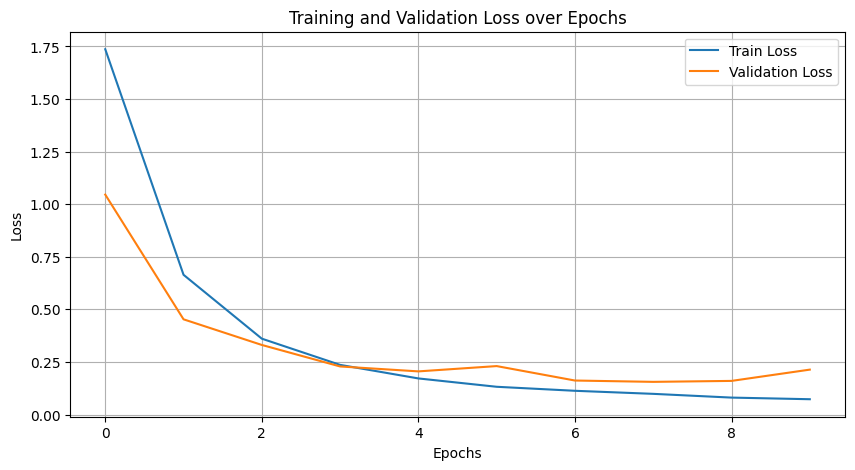

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [6]:

model = Net()
model = model.to(device)
model.load_state_dict(torch.load("Net_best.pth", map_location=device))

model.eval()
avg_train_performance = 0.0
avg_val_performance = 0.0
for images, targets in tqdm(full_dataloader):
    images = images.to(device, non_blocking=True)
    targets = targets.to(device, non_blocking=True).type(torch.long)

    logits, arg_max_pred = model(images)

    avg_train_performance += (arg_max_pred == targets).sum().item() / targets.size(0)

avg_train_performance = avg_train_performance / len(full_dataloader)
print(f"Train Accuracy: {avg_train_performance:.4f}")

model.eval()
val_loss = 0.0
with torch.no_grad():
    for images, targets in val_dataloader:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True).type(torch.long)
        logits, arg_max_pred = model(images)

        avg_val_performance += (arg_max_pred == targets).sum().item() / targets.size(0)

avg_val_performance = avg_val_performance / len(val_dataloader)
print(f"Train Performance = {avg_train_performance:.4f}, Val Performance = {avg_val_performance:.4f}")

/home/user/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:736: UserWarning: Can't initialize amdsmi - Error code: 34
  warnings.warn(f"Can't initialize amdsmi - Error code: {e.err_code}")
100%|██████████| 195/195 [03:09<00:00,  1.03it/s]


Train Accuracy: 0.9669
Train Performance = 0.9669, Val Performance = 0.9617


Iteration 1/50
Loss = 2.3019
Iteration 2/50
Loss = 2.3025
Iteration 3/50
Loss = 2.3020
Iteration 4/50
Loss = 2.3021
Iteration 5/50
Loss = 2.3056
Iteration 6/50
Loss = 2.3014
Iteration 7/50
Loss = 2.3035
Iteration 8/50
Loss = 2.3018
Iteration 9/50
Loss = 2.3027
Iteration 10/50
Loss = 2.3049
Iteration 11/50
Loss = 2.3029
Iteration 12/50
Loss = 2.3010
Iteration 13/50
Loss = 2.3012
Iteration 14/50
Loss = 2.2998
Iteration 15/50
Loss = 2.3040
Iteration 16/50
Loss = 2.3046
Iteration 17/50
Loss = 2.3036
Iteration 18/50
Loss = 2.2975
Iteration 19/50
Loss = 2.2949
Iteration 20/50
Loss = 2.2874
Iteration 21/50
Loss = 2.2439
Iteration 22/50
Loss = 2.1717
Iteration 23/50
Loss = 2.1365
Iteration 24/50
Loss = 2.0179
Iteration 25/50
Loss = 1.9814
Iteration 26/50
Loss = 1.9228
Iteration 27/50
Loss = 2.0511
Iteration 28/50
Loss = 1.9730
Iteration 29/50
Loss = 1.9601
Iteration 30/50
Loss = 1.9109
Iteration 31/50
Loss = 1.7833
Iteration 32/50
Loss = 1.8482
Iteration 33/50
Loss = 2.6822
Iteration 34/50
Los

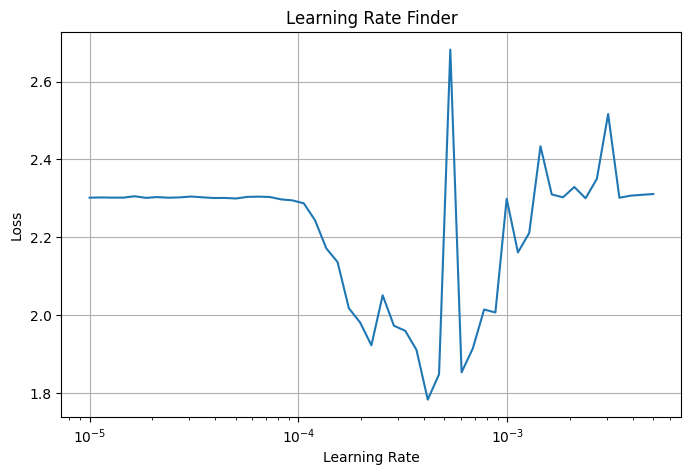

In [6]:
import torch
from torch import nn, optim

dataset = TensorDataset(X_train, y_train)
full_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-7)
loss_fn = nn.CrossEntropyLoss()

lrs = []
losses = []

lr_start = 1e-5
lr_end = 0.5e-2
num_iters = 50
mult = (lr_end / lr_start) ** (1/num_iters)
lr = lr_start

for i, (X_batch, y_batch) in enumerate(full_dataloader):
    if i > num_iters:
        break

    print(f"Iteration {i+1}/{num_iters}")
    X_batch, y_batch = X_batch.to(device), y_batch.to(device).type(torch.long)
    optimizer.zero_grad()

    logits, arg_max_pred = model(X_batch)

    loss = loss_fn(logits, y_batch)
    loss.backward()
    print(f"Loss = {loss.item():.4f}")
    optimizer.step()

    lrs.append(lr)
    losses.append(loss.item())


    lr *= mult
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

plt.figure(figsize=(8,5))
plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning Rate Finder")
plt.grid(True)
plt.show()